## BBC News Classification with NMF Project

University of Colorado, Boulder - CSCA 5632: Unsupervised Algorithms in Machine Learning

### Project

This project is about categorizing the BBC News articles using matrix factorization to predict the category. The project will work to follow a typical machine learning project, with an exception that the specific unsupervised model, Non-negative Matrix Factorization (NMF), is already determined. After evaluations have been perfomed for the NMF model, the project will then select and compare the performance for against a supervised model. The guidelines for this project are as follows:

#### Step 1. Exploratory Data Analysis

In this section we will inspect, visualize, and clean the data. As part of the process, we will also select a word embedding method and review associated visualizations and statistics. Following a review of the EDA, we will then generate a plan for the analysis, including data cleaning, preprocessing, and feature engineering steps.

#### Step 2. Building and training the unsupervised model

In this section we will build a model using the Non-negative Matrix Factorization method and predict train and test data labels. The model's performance across various hyperparameter configurations will be evaluated to determine the optimal configuration. The performance will be inpected through results of the accuracy score and confusion matrix. Finally, we may look at additional methods to improve the final model performance.

#### Step 3. Compare with supervised learning

In this section we will evaluate and select a supervised model to generate the predicted category and compare the test results with the NMF model. This comparison will also include an evaluation of how each model performs based on the size of the training data.

#### Step 4. Project Report and Conclusion

Finally, we will evaluate the project results.

Import the necessary libraries

In [ ]:
from collections import Counter
import itertools
import numpy as np
import os
import pandas as pd
import re

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import spacy

# Download the following required data resources if not already downloaded and needed

# NLTK stopwords
nltk.download('stopwords', quiet=True)

# If using WordNetLemmatizer with POS tag support, you'll need the following NLTK data sets
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# If using the spaCy lemmatizer, you'll need the following spaCy data set downloaded
#  for spaCy english words:
# !python -m spacy download en_core_web_sm


In [64]:
# list project data files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input\learn-ai-bbc\BBC News Sample Solution.csv
/kaggle/input\learn-ai-bbc\BBC News Test.csv
/kaggle/input\learn-ai-bbc\BBC News Train.csv


### Load the data files

In [127]:
bbcnews_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
bbcnews_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
submission_sample = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

### Step 1. Exploratory Data Analysis (EDA)

#### Examine data sets

Let's take a look at the train, test, and sample submission data sets

In [90]:
print(f'Train data set: {bbcnews_train.shape}\n')
print(bbcnews_train.info())
bbcnews_train.head()

Train data set: (1490, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [69]:
print(f'Test data set: {bbcnews_test.shape}\n')
print(bbcnews_test.info())
bbcnews_test.head()

Test data set: (735, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [70]:
print(f'Sample submission data set: {submission_sample.shape}\n')
submission_sample

Sample submission data set: (735, 2)



,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


Confirmed that the training data has 1490 rows, containing no NaN/None/null values, and the following three columns:
* ArticleId - Article id, unique # given to the record
* Text - text of the header and article
* Category - cateogry of the article (tech, business, sport, entertainment, politics)

The test set has 735 rows, containing no NaN/None/null values, with the ArticleId and Text data, without the Category label. This is the data set that will be used for the submission.

The sample submission format inclcudes only the ArticleId and predicted Category.

#### Explore distributions of data by category

In [73]:
# list categories and count for each
bbcnews_train.groupby('Category').count()

,ArticleId,Text
Category,,
business,336,336
entertainment,273,273
politics,274,274
sport,346,346
tech,261,261


#### Let's generate some visualizations

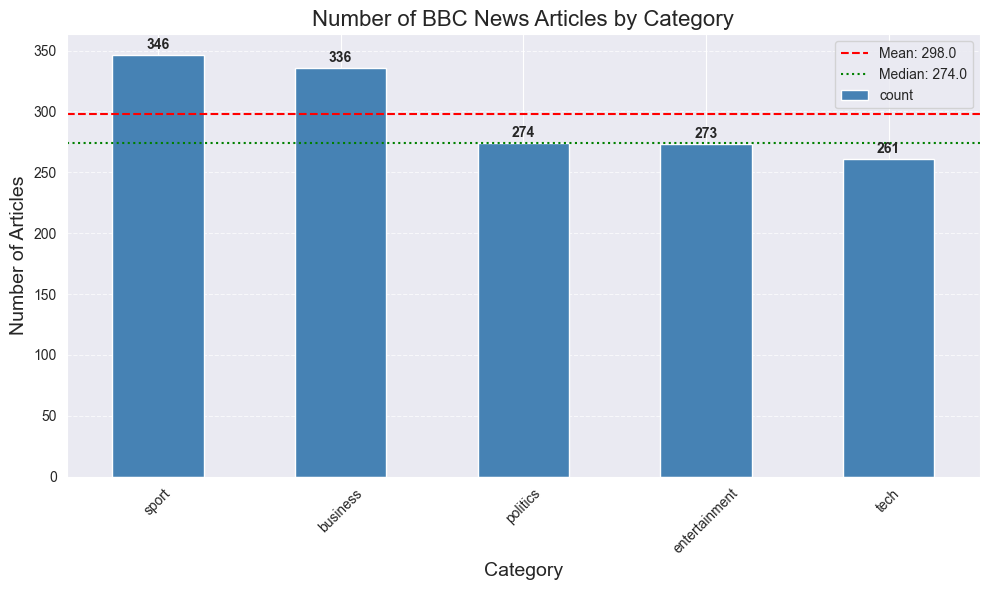

In [87]:
# Plot the number of articles in each category

# Get counts by categorry
category_counts = bbcnews_train['Category'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = category_counts.plot(kind='bar', color='steelblue')

# Add horizontal lines for mean and median
ax.axhline(y=mean_count, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {category_counts.mean():.1f}')
ax.axhline(y=category_counts.median(), color='green', linestyle=':', linewidth=1.5, label=f'Median: {category_counts.median():.1f}')

plt.title('Number of BBC News Articles by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Add the counts on top of each bar
for i, count in enumerate(category_counts):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


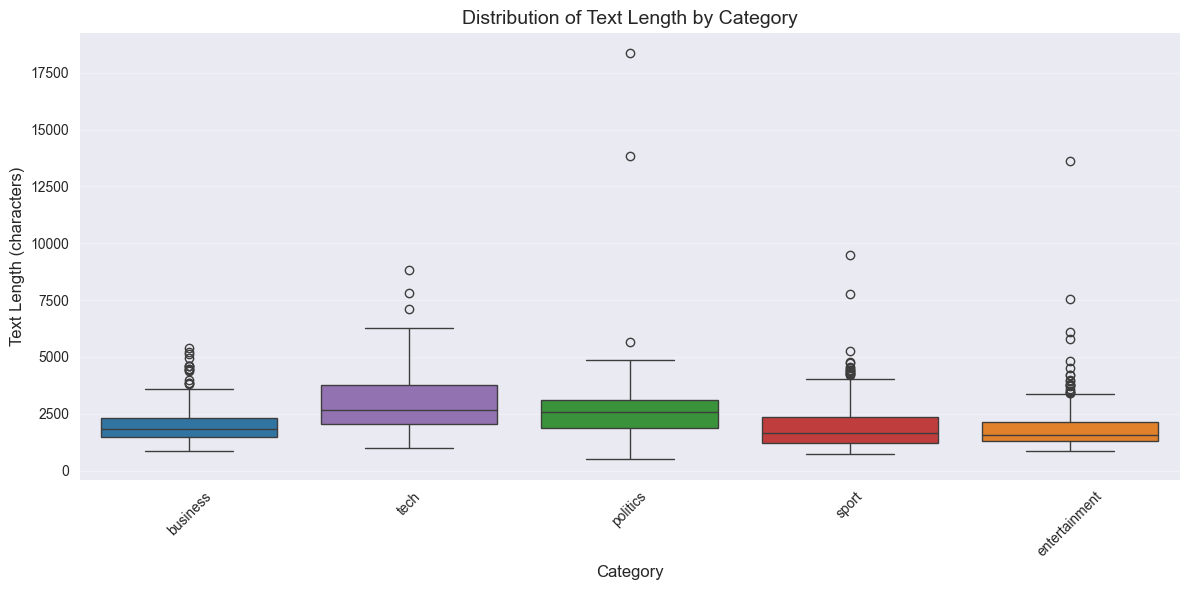

In [82]:
# Distribution of article length by category

# Calculate the length for each article
bbcnews_train['text_length'] = bbcnews_train['Text'].apply(len)

# Create a box plot to compare text length by category
category_colors = {
    'business': '#1f77b4',      # blue
    'entertainment': '#ff7f0e', # orange
    'politics': '#2ca02c',      # green
    'sport': '#d62728',         # red
    'tech': '#9467bd'           # purple
}
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='text_length', data=bbcnews_train, palette=category_colors, hue='Category')
plt.title('Distribution of Text Length by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

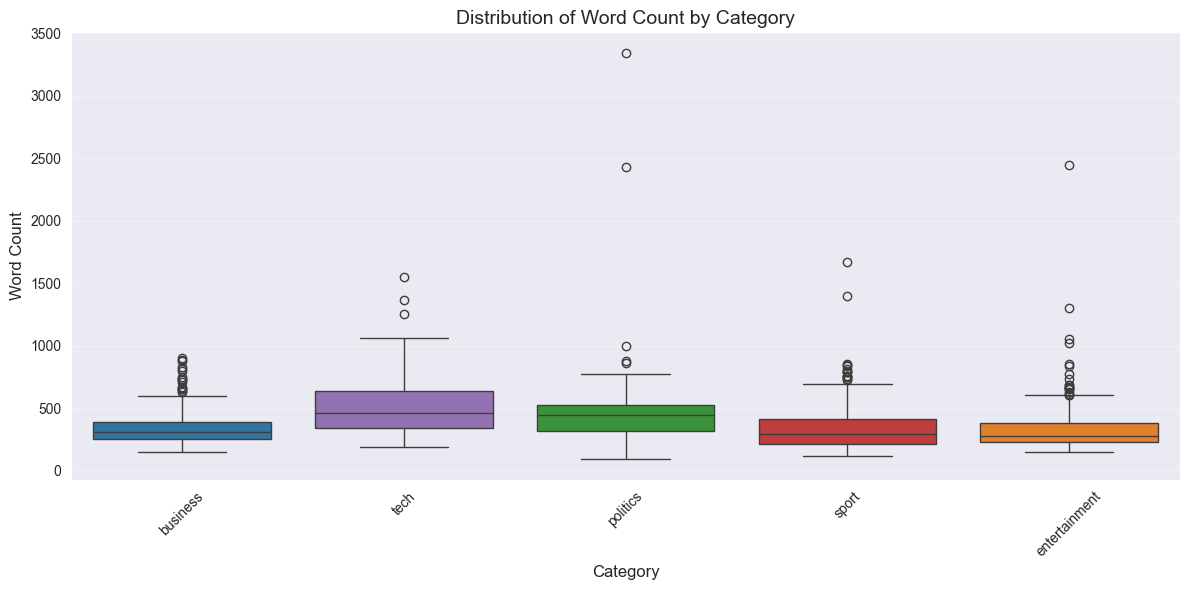

In [96]:
# Plot the distribution of word counts

# Calculate the word count for each article
bbcnews_train['word_count'] = bbcnews_train['Text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='word_count', data=bbcnews_train, palette=category_colors, hue='Category')
plt.title('Distribution of Word Count by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### Let's explore the distribution of words across all articles

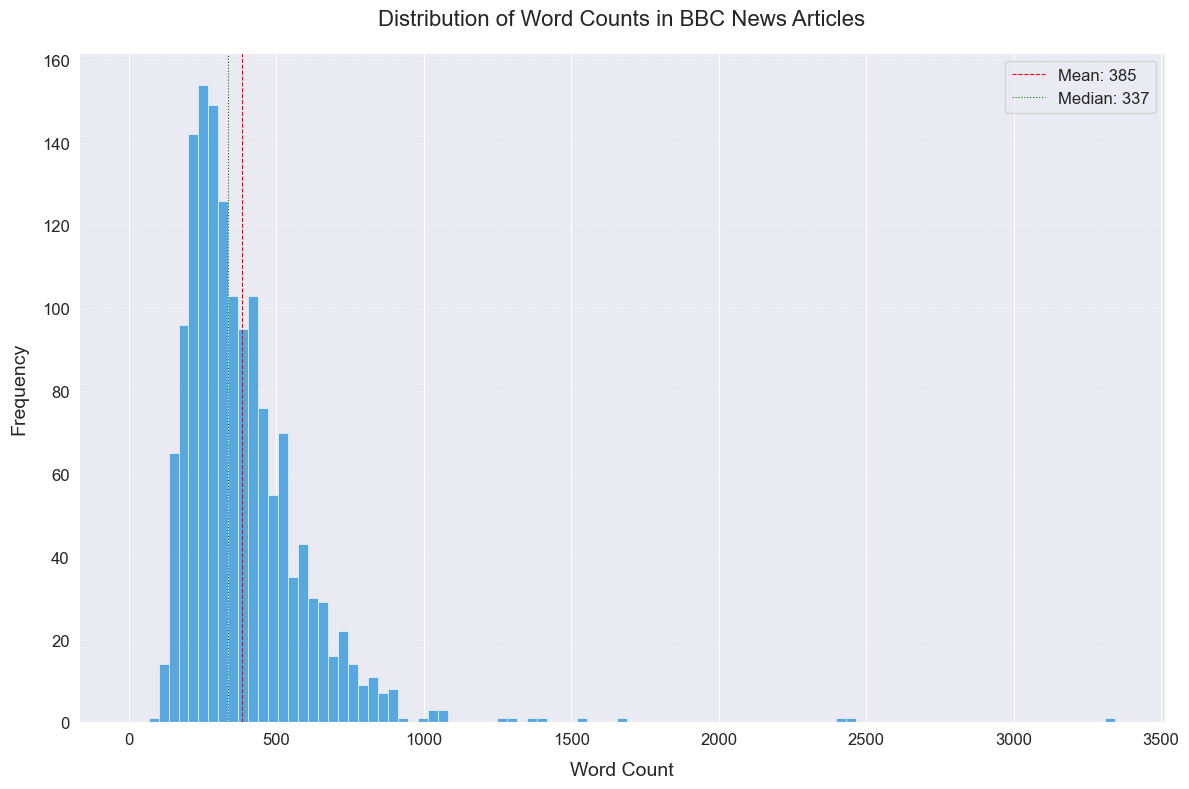

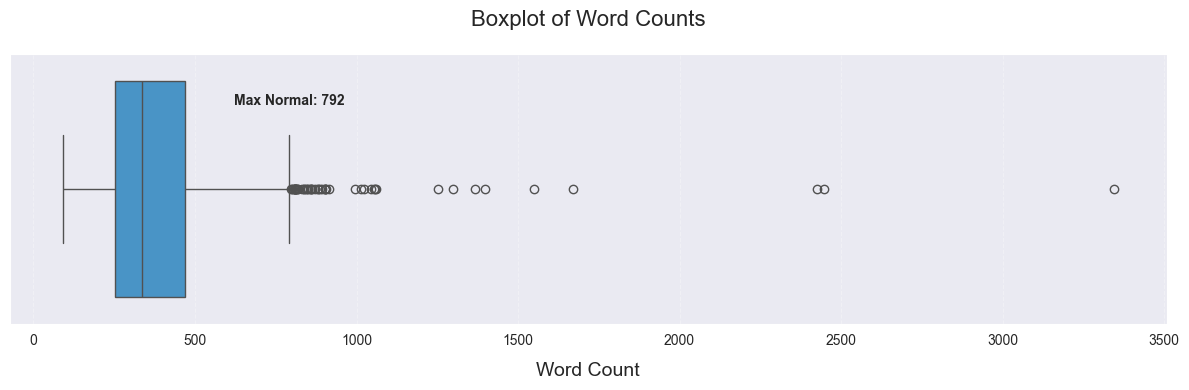

In [100]:
# The the distribution of the word count for all articles
plt.figure(figsize=(12, 8))

# Create the histogram of word counts
bins = np.linspace(0, bbcnews_train['word_count'].max(), 100)
n, bins, patches = plt.hist(bbcnews_train['word_count'], bins=bins,
                            color='#3498db', alpha=0.8, edgecolor='white', linewidth=0.5)

# Calculate statistics
mean_val = bbcnews_train['word_count'].mean()
median_val = bbcnews_train['word_count'].median()
mode_val = bbcnews_train['word_count'].mode()[0]
std_val = bbcnews_train['word_count'].std()

# Add vertical lines for mean and median (with thinner lines)
plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=0.8, label=f'Mean: {mean_val:.0f}')
plt.axvline(x=median_val, color='green', linestyle=':', linewidth=0.8, label=f'Median: {median_val:.0f}')

plt.title('Distribution of Word Counts in BBC News Articles', fontsize=16, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Associated boxplot for the word count distribution
plt.figure(figsize=(12, 4))
ax = sns.boxplot(x=bbcnews_train['word_count'], color='#3498db')

# Calculate and display whisker values
Q1 = bbcnews_train['word_count'].quantile(0.25)
Q3 = bbcnews_train['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Text annotations
plt.text(upper_whisker, -0.3, f'Max Normal: {upper_whisker:.0f}', ha='center', va='bottom', fontweight='bold')  # plot upper whisker
plt.title('Boxplot of Word Counts', fontsize=16, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


The data looks to have some significant outliers, where the number of words in some articles exceed the max normal of 792. Given that these are news articles, a general principle in jouranlism is to provide the most newsworthy information (who, what, when, where, why) towards the beginning of the article (inverted pyramid structure). Based on this principle, we can likely truncate the longer articles and still retain the necessary text to categorize it appropriately. We can play with some options and compare the results.

#### Check for duplicates

In [91]:
bbcnews_train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

It looks like we have 50 articles where the text is not unique. Let's explore that further.

In [92]:
# Find duplicate rows in the training dataset where 'Text' is not unique
train_duplicates = bbcnews_train[bbcnews_train.duplicated(subset=['Text'], keep=False)]
print(f"Number of duplicate rows: {len(train_duplicates)}")
display(train_duplicates.sort_values(by='Text'))


Number of duplicate rows: 100


,ArticleId,Text,Category
494,1326,ask jeeves joins web log market ask jeeves has...,tech
228,1098,ask jeeves joins web log market ask jeeves has...,tech
1430,1042,aviator creator in oscars snub the man who s...,entertainment
695,374,aviator creator in oscars snub the man who s...,entertainment
443,1847,blind student hears in colour a blind studen...,tech
...,...,...,...
1047,789,virus poses as christmas e-mail security firms...,tech
1409,957,web radio takes spanish rap global spin the ra...,tech
616,110,web radio takes spanish rap global spin the ra...,tech
63,2017,what high-definition will do to dvds first it ...,tech


Let's verify that articles with identical text is also labeled with the same category

In [93]:
# Group duplicates by Text and check if all rows in each group have the same Category
print("Analysis of duplicate texts in training dataset:")
for text, group in train_duplicates.groupby('Text'):
    categories = group['Category'].unique()
    if len(categories) == 1:
        print(f"Text (truncated): '{text[:50]}...' has {len(group)} duplicates, all with category: {categories[0]}")
    else:
        print(f"Text (truncated): '{text[:50]}...' has {len(group)} duplicates with different categories: {categories}")

# Count how many duplicate texts have consistent vs inconsistent categories
same_category = 0
different_category = 0

for text, group in train_duplicates.groupby('Text'):
    if len(group['Category'].unique()) == 1:
        same_category += 1
    else:
        different_category += 1

print(f"\nSummary:")
print(f"- Duplicate texts with the same category: {same_category}")
print(f"- Duplicate texts with different categories: {different_category}")

Analysis of duplicate texts in training dataset:
Text (truncated): 'ask jeeves joins web log market ask jeeves has bou...' has 2 duplicates, all with category: tech
Text (truncated): 'aviator  creator  in oscars snub the man who said ...' has 2 duplicates, all with category: entertainment
Text (truncated): 'blind student  hears in colour  a blind student ha...' has 2 duplicates, all with category: tech
Text (truncated): 'bortolami predicts dour contest italy skipper marc...' has 2 duplicates, all with category: sport
Text (truncated): 'britons fed up with net service a survey conducted...' has 2 duplicates, all with category: tech
Text (truncated): 'brown outlines third term vision gordon brown has ...' has 2 duplicates, all with category: politics
Text (truncated): 'california sets fines for spyware the makers of co...' has 2 duplicates, all with category: tech
Text (truncated): 'camera phones are  must-haves  four times more mob...' has 2 duplicates, all with category: tech
Text (tru

We found no article text duplicates with different categories, so we should just remove the duplicates. Let's take a quick look at the structure of an article.

In [104]:
print(f'Article[0]: {bbcnews_train['Text'][0]}\n')
print(f'Article[1]: {bbcnews_train['Text'][1]}\n')

Article[0]: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by world

### Analysis Plan

Based on the findings from the EDA analysis, we will perform the following actions in the preprocessing steps:

1. Delete duplicate rows,
2. Enable word count truncation limits within the text cleanup process,
3. Convert to lowercase (even though the viewed articles are already lowercase),
4. Remove punctuation,
5. Remove numbers/digits,
6. Remove standard english stopwords
7. Evaluate removing short words (length < 3 chars)

#### Unsupervised model

Since the unsupervised model, Non-negative Matrix Factorization (NMF), has been predetermined for the initial evaluation, we only plan to focus on the following aspects for tuning the prediction accuracy:

* Text Preprocessing - testing different options for tokenization and normalization (e.g., stemming/lemmatizing)
* Vectorizing - for this project we are vectorizing using the TD-IDF vectorizer
* Hyperparameter tuning - the project will leverage GridSearchCV to determine target hyperparameters for the final model

#### Supervised model

The final steps in the project will be to evaluate and select a supervised model to classify the category and then compare the results with the unsupervised approach. GridSearchCV will again be used to evaluate the different models and then tune the final supervised model. The following supervised learning models will be evaluated:

* Random Forests
* SVM (LinearSVC)
* LogisticRegression


### Data Preprocessing

Remove ~50 articles with duplicated text

In [128]:
# remove duplicates
bbcnews_train = bbcnews_train.drop_duplicates(subset = ['Text'], keep = 'first')
remaining_dups = bbcnews_train[bbcnews_train.duplicated(subset=['Text'], keep=False)]
print(f"Remaining duplicates in the training dataset: {len(remaining_dups)}")

Remaining duplicates in the training dataset: 0


#### TextCleaner

Create a custom transformer to perform the cleaning, vectorization, and normalization functions on the article text. Using a custom transformer for the text cleanup enables use within a pipeline process. The text cleanup function supports the following Text Preprocessing methods:
* Simple Tokenization - split text into words
* spaCy Lemmitizer - spaCy library for tokenization and lemmatizing
* WordNet Lemmatizer - Simple tokenization with NLTK WordNet lemmatizing using part of speech (POS) tagging
* Snowball Stemmer - Simple tokenization with NLTK Snowball stemming

In [121]:
# Create a custom transformer to perform text cleanup (usable in pipeline later)
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, min_word_length = 2, max_word_count = 0, method = 'simple', additional_words = None, stop_words = None):
        self.min_word_length = min_word_length
        self.max_word_count = max_word_count
        self.method = method
        self.additional_words = additional_words
        self.stop_words = stop_words if stop_words else set(stopwords.words('english'))
        self.remove_words = self.stop_words if not self.additional_words else self.stop_words.union(self.additional_words)

    # empty fit function to support use in pipeline
    def fit(self, X, y = None):
        return self

    # transform function for _cleanup_text to support use in pipeline
    def transform(self, X):
        if hasattr(X, 'apply'):
            return X.copy().apply(self._cleanup_text)
        else:
            return [self._cleanup_text(text) for text in X]

    # Function to perform the text cleanup and stem/lemmatize as specified
    def _cleanup_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove numbers
        text = re.sub(r'\d+', ' ', text)

        # Process words (lemmatize, removing stopwords and additional words supplied, short words, and extra spaces)
        match self.method:
            case 'spaCy' | 'spacy':
                words = self._spacy_lemma(text)
            case 'wordnet':
                words = self._wordnet_lemma(text)
            case 'snowball':
                words = self._snowball_stemmer(text)
            case _:  # default to 'simple'
                words = self._simple_tokens(text)

        # Limit to max word count if specified
        if self.max_word_count > 0:
            words = words[:self.max_word_count]

        return ' '.join(words)

    # Simple word tokens, removing words in the remove_words list and short words
    def _simple_tokens(self, text):
        tokens = text.split()
        return [token for token in tokens if token not in self.remove_words and len(token) > self.min_word_length]

    # spaCy lemmatizer
    def _spacy_lemma(self, text):
        # spaCy english words - Needed if using the spaCy lemmatizer option and not already downloaded - see Imports

        nlp = spacy.load("en_core_web_sm")  # For spaCy lemmatizing option
        tokens = nlp(text)  # use spaCy to generate tokens

        # Process words (lemmatize, removing stopwords and additional words supplied, short words, and extra spaces)
        return [token.lemma_ for token in tokens if token.text not in self.remove_words
                 and token.lemma_ not in self.remove_words and len(token) > self.min_word_length and not token.is_space]

    # WordNetLemmatizer
    def _get_wordnet_pos(self, nltk_tag):
        # Map for most common matches on the first letter of the tag
        pos_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}

        # Map NLTK POS tags to WordNet POS tags
        if nltk_tag[0] in pos_map:
            return pos_map[nltk_tag[0]]
        elif nltk_tag in ('MD', 'TO'):  # Modal, infinitive marker
            return wordnet.VERB
        else:
             return wordnet.NOUN  # Default to Noun for other cases

    def _wordnet_lemma(self, text):
        # NLTK data needed for wordnet and pos_tag - see Imports
        lemmatizer = WordNetLemmatizer()
        tokens = self._simple_tokens(text)

        # Get POS (part of speech) tags
        tagged_tokens = pos_tag(tokens)

        # Lemmatize with POS tag
        lemmatized_words = []
        for word, tag in tagged_tokens:
            if word not in self.remove_words and len(word) > self.min_word_length:
                # Get the WordNet POS tag
                wordnet_pos = self._get_wordnet_pos(tag)

                # Lemmatize with the appropriate POS tag
                lemma = lemmatizer.lemmatize(word, wordnet_pos)
                lemmatized_words.append(lemma)

        return lemmatized_words

    # SnowballStemmer
    def _snowball_stemmer(self, text):
        stemmer = SnowballStemmer("english")
        tokens = self._simple_tokens(text)

        # apply stemming
        words = [stemmer.stem(word) for word in tokens]

        return words


#### Quick evaluation on word tokenization

Using the TextCleaner transformer, we are going to perform a quick evaluation to see if there are any common words across all groups that could impact categorization

In [129]:
# Cleanup the article Text - default simple method
text_cleaner = TextCleaner(method = 'simple')
bbcnews_train['Text_cleaned'] = text_cleaner.transform(bbcnews_train['Text'])
print("Original Text: ", bbcnews_train['Text'][0], "\n\n")
print("Cleaned Text: ", bbcnews_train['Text_cleaned'][0])

Original Text:  worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by w

In [130]:
# Find most common words in each category and across categories

# Helper function to get the top N words from a category
def get_top_n_words(category, top_n=30):
    # Get the articles for the specified category
    category_data = bbcnews_train[bbcnews_train['Category'] == category]

    # Combine all cleaned text for this category
    all_words = ' '.join(category_data['Text_cleaned']).split()

    # Count word frequencies and get the top N
    top_words = Counter(all_words).most_common(top_n)

    return top_words


def get_top_m_common_words(top_m=30, top_n=100, sort_by='average'):
    # Get the top_n words for each category
    categories = bbcnews_train['Category'].unique()
    category_words = {}
    for category in categories:
        category_words[category] = dict(get_top_n_words(category, top_n))

    # Find common words in all categories
    common_words = set(category_words[categories[0]].keys())
    for category in categories[1:]:
        common_words = common_words.intersection(set(category_words[category].keys()))

    print(f"The number of common words in all categories is {len(common_words)}")

    # Get the counts for each word
    # Create a DataFrame with counts for each word in each category
    data = []
    for word in common_words:
        row = {'word': word}
        counts = []
        for cat in categories:
            count = category_words[cat][word]
            row[cat] = count
            counts.append(count)

        # Calculate statistics
        row['total_count'] = sum(counts)
        row['avg_count'] = np.mean(counts)
        row['min_count'] = min(counts)
        row['max_count'] = max(counts)
        row['std_dev'] = np.std(counts)
        row['cv'] = row['std_dev'] / row['avg_count'] if row['avg_count'] > 0 else 0  # Coefficient of variation

        data.append(row)
    result_df = pd.DataFrame(data)

    # Sort based on the specified method
    match sort_by:
        case 'total':
            result_df = result_df.sort_values('total_count', ascending=False)
        case 'min_count':
            result_df = result_df.sort_values('min_count', ascending=False)
        case 'consistency':
            result_df = result_df.sort_values('cv', ascending=True)  # Lower CV means more consistent across categories
        case _:  # default to 'average'
            result_df = result_df.sort_values('avg_count', ascending=False)

    result_df = result_df.reset_index(drop=True)

    # Return top m common words
    return result_df.head(top_m)


common_category_words = get_top_m_common_words(top_n=30)
display(common_category_words)

The number of common words in all categories is 6


,word,business,tech,politics,sport,entertainment,total_count,avg_count,min_count,max_count,std_dev,cv
0,said,1098,980,1412,629,576,4695,939.0,576,1412,309.373561,0.329471
1,would,309,290,685,233,135,1652,330.4,135,685,187.349513,0.567038
2,year,452,224,175,330,304,1485,297.0,175,452,95.263844,0.320754
3,also,279,310,298,212,267,1366,273.2,212,310,34.019994,0.124524
4,new,273,324,271,202,229,1299,259.8,202,324,41.739190,0.160659
5,one,183,314,185,261,259,1202,240.4,183,314,50.102295,0.208412


In [131]:
# Create and display treemaps for the top words in each category
# Helper function to create the treemaps for each category
def create_category_treemap(category, top_n=30):

    # Create dataframe for treemap
    treemap_data = pd.DataFrame(get_top_n_words(category, top_n), columns=['word', 'count'])

    # Custom color schemes for each category
    color_schemes = {
        'business': 'Blues',
        'entertainment': 'Teal',
        'politics': 'Greens',
        'sport': 'Reds',
        'tech': 'Purples'
    }

    # Create treemap
    fig = px.treemap(
        treemap_data,
        path=['word'],
        values='count',
        title=f'Most Common Words in {category.capitalize()} Articles',
        color='count',
        color_continuous_scale=color_schemes.get(category, 'Viridis'),
        height=400,
        width=1000
    )

    fig.update_layout(
        margin=dict(t=50, l=25, r=25, b=25),
        font=dict(size=14)
    )

    fig.update_traces(
        textinfo='label+value',
        hovertemplate='<b>%{label}</b><br>Count: %{value}<extra></extra>'
    )

    return fig


for category in bbcnews_train['Category'].unique():
    fig = create_category_treemap(category)
    fig.show()


#### Remove Common Words

Looking at the six common words across all categories (said, would, year, also, new, one), and their prevalence within the top words, we will remove them from the text along with the standard stop words.

In [132]:
# Remove the common words from the word list
remove_common = common_category_words['word'].tolist()

# Cleanup the article Text
text_cleaner = TextCleaner(additional_words=remove_common)
bbcnews_train['Text_cleaned'] = text_cleaner.transform(bbcnews_train['Text'])

# Visualize the word treemaps with the common words removed
for category in bbcnews_train['Category'].unique():
    fig = create_category_treemap(category)
    fig.show()

#### Create training and test data sets

In [ ]:
# Split the current Train data set into a train and test sets to evaluate supervised model(s)
X_train, X_test, y_train, y_test = train_test_split(
    bbcnews_train.Text,
    bbcnews_train.Category,
    test_size=0.2,
    random_state=42,
    stratify=bbcnews_train.Category  # Maintain class distribution
)

### Step 2. Building and training the unsupervised model

Create a helper function to match prediction scores with category labels.  (re-using a function from a previous class module with a minor modification for the inital lable order)

In [133]:
# Helper function to match categories with NMF results
def label_permute_compare(ytdf,yp,labels):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74
    """
    print(f"using labels list: {labels}")
    perms = [list(perm) for perm in itertools.permutations(labels, len(labels))]  # create a list of permutations for the labels

    # convert target labels df to array
    ytlist = ytdf.iloc[:, 0].to_numpy()

    # iterate through the permutations and calculate accuracy
    label_acc = []
    for perm in perms:
        # create an array of labels for the prediction, using the permutation list and the cluster number as the index
        yp_labels = np.array(perm)[yp]
        # get the accurcy score using the ground truth labels against this iteration of prediction labels
        label_acc.append((accuracy_score(ytlist, yp_labels), perm))  #

    # get the results with the highest accuracy
    best_accuracy = max(label_acc, key=lambda x: x[0])
    print(f"best accuracy: {best_accuracy[0]}")
    print(f"best class label order (0, 1, 2, 3, 4) = {best_accuracy[1]}")

    # map the best label order back to the original labels list for the permuted label order
    indices = [labels.index(label) for label in best_accuracy[1]]
    print(f"index order from starting labels lists: {indices}\n")

    return tuple(indices), best_accuracy[0]


Create the pipeline for the process

In [134]:
# Number of categories
n_categories = len(bbcnews_train['Category'].unique())

# Create a pipeline to clean, tranform, and vectorize the text and perform NMF
nmf_pipeline = Pipeline([
    ('text_cleaner', TextCleaner(method='simple', additional_words=remove_common)),
    ('tfidf', TfidfVectorizer(
        min_df=5,
        max_df=0.95,
        analyzer='word',
        ngram_range=(1, 2),
        sublinear_tf=True,
        token_pattern=r'\b\w+\b'
    )),
    ('nmf', NMF(
        n_components=n_categories,
        random_state=42,
        max_iter=200,
        solver='mu',
        beta_loss='kullback-leibler',
        alpha_H=0.0,
        l1_ratio=0.5,
        init='nndsvda'
    ))
])

Clean the article text (four options tested)

* Simple method, removing common words

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common))

    * accuracy = 0.9369, time = 3s

* spaCy lemmatizer

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common, method = 'spaCy'))

    * accuracy = 0.9368, time = 10m50s

* Wordnet lemmatizer with POS tag

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common, method = 'wordnet'))

    * accuracy = 0.9563, time = 19s

* Snowball stemmer

    * bbcnews_train['Text_cleaned'] = bbcnews_train['Text'].apply(lambda text: cleanup_text(text, additional_words=remove_common, method = 'snowball'))

    * accuracy = 0.9625, time = 5s


In [ ]:
# Clean, transform, vectorize, and fit the article text
y_hat_train = nmf_pipeline.fit_transform(bbcnews_train['Text'])

# Extract and display topics
print("\nTopics extracted from training data:")
feature_names = nmf_pipeline.named_steps['tfidf'].get_feature_names_out()
for topic_idx, topic in enumerate(nmf_pipeline.named_steps['nmf'].components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx}: {' '.join(top_words)}")
print("\n")

# Assign the dominant topic as the prediction
y_pred = y_hat_train.argmax(axis=1)

# Get the true categories
y_true = pd.DataFrame(bbcnews_train['Category'], columns=['Category'])

# Get the category permutation mapping that achieves the highest accuracy for the clusters
categories = np.unique(y_true).tolist()
topic_to_category_idx, accuracy = label_permute_compare(y_true, y_pred, categories)

# Map the predicted topics to category names from the permutation results
category_mapping = {i: categories[idx] for i, idx in enumerate(topic_to_category_idx)}

# Convert the topic numbers to category names
predicted_categories = [category_mapping[topic] for topic in y_pred]

# Add predictions to the training dataframe
bbcnews_train['Predicted_Category'] = predicted_categories

# Display the training accuracy
accuracy = accuracy_score(bbcnews_train['Category'], bbcnews_train['Predicted_Category'])
print(f"Train Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(bbcnews_train['Category'], bbcnews_train['Predicted_Category'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.show()


In [ ]:
# Generate predictions for Test data set
nmf_test = bbcnews_test.copy()

# Predict the target category on the Test data set using the train pipeline
y_hat_test = nmf_pipeline.transform(nmf_test['Text'])
y_pred = y_hat_test.argmax(axis=1)
predicted_categories = [category_mapping[topic] for topic in y_pred]
nmf_test['Category'] = predicted_categories

# drop unneeded columns
nmf_test = nmf_test.drop(['Text'], axis=1)
nmf_test.head(10)


In [ ]:
# save submission
try:
    nmf_test.to_csv('submission.csv', index=False)
except:
    ...


### Model Comparison

In [ ]:
# Support Vector Machine model
svm_pipeline = Pipeline([
    ('cleaner', TextCleaner(method='wordnet', additional_words=remove_common)),
    ('tfidf', TfidfVectorizer(
        min_df=5,
        max_df=0.95,
        analyzer='word',
        ngram_range=(1, 2),
        sublinear_tf=True,
        token_pattern=r'\b\w+\b'
    )),
    ('classifier', LinearSVC(C=1.0, dual=False))
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy on test set: {accuracy_svm:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))